In [2]:
# Data Manipulation
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
# Dataset exploring
import os
# Dataset generation
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
# Transfert learning
from keras.applications import *
# Optimizer
from keras.optimizers import *
# Keras layers
from keras.layers import *
# Keras model
from keras.models import Model

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
import keras

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [6]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [7]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

fruits-fresh-and-rotten-for-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!ls

dataset		       fruit_classifier_org.h5
fruit_classifier.h5    fruits-fresh-and-rotten-for-classification.zip
fruit_classifier.hdf5  kaggle.json


In [9]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  fruits-fresh-and-rotten-for-classification.zip
replace dataset/dataset/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
classes = []
class_counter = 0

for dirname, _, filenames in os.walk('/content/gdrive/My Drive/Kaggle/dataset/train/'):
    if dirname.endswith('/'):
        continue
    else:
        classes.append({dirname.split('/')[-1]: 0})
    file_count = 0
    for filename in filenames:
        file_count += 1
    classes[class_counter][dirname.split('/')[-1]] = file_count
    class_counter += 1
    
print('{:<15} {:<15}'.format('Class', 'Number of instances'))
print()
for d in classes:
    [(k, v)] = d.items()
    print('{:<15} {:<15}'.format(k, v))

Class           Number of instances

freshapples     1693           
freshbanana     1581           
freshoranges    1466           
rottenapples    2342           
rottenbanana    2224           
rottenoranges   1595           


In [11]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
from keras.utils  import to_categorical
import pickle


In [12]:
def load_rand():
    X=[]
    dir_path='/content/gdrive/My Drive/Kaggle/dataset/train/'
    for sub_dir in tqdm(os.listdir(dir_path)):
        print(sub_dir)
        path_main=os.path.join(dir_path,sub_dir)
        i=0
        for img_name in os.listdir(path_main):
            if i>=6:
                break
            img=cv2.imread(os.path.join(path_main,img_name))
            img=cv2.resize(img,(100,100))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            X.append(img)
            i+=1
    return X
    

In [13]:
X=load_rand()

  0%|          | 0/6 [00:00<?, ?it/s]

freshapples


 17%|█▋        | 1/6 [00:03<00:15,  3.02s/it]

freshbanana


 33%|███▎      | 2/6 [00:05<00:11,  2.92s/it]

freshoranges


 50%|█████     | 3/6 [00:08<00:08,  2.81s/it]

rottenapples


 67%|██████▋   | 4/6 [00:11<00:05,  2.80s/it]

rottenbanana


 83%|████████▎ | 5/6 [00:13<00:02,  2.74s/it]

rottenoranges


100%|██████████| 6/6 [00:15<00:00,  2.65s/it]


In [14]:
X=np.array(X)
X.shape

(36, 100, 100, 3)

In [15]:
def show_subpot(X,title=False,Y=None):
    if X.shape[0]==36:
        f, ax= plt.subplots(6,6, figsize=(40,60))
        list_fruits=['rottenoranges', 'rottenapples', 'freshbanana', 'freshoranges', 'rottenbanana', 'freshapples']
        for i,img in enumerate(X):
            ax[i//6][i%6].imshow(img, aspect='auto')
            if title==False:
                ax[i//6][i%6].set_title(list_fruits[i//6])
            elif title and Y is not None:
                ax[i//6][i%6].set_title(Y[i])
        plt.show()
    else:
        print('Cannot plot')

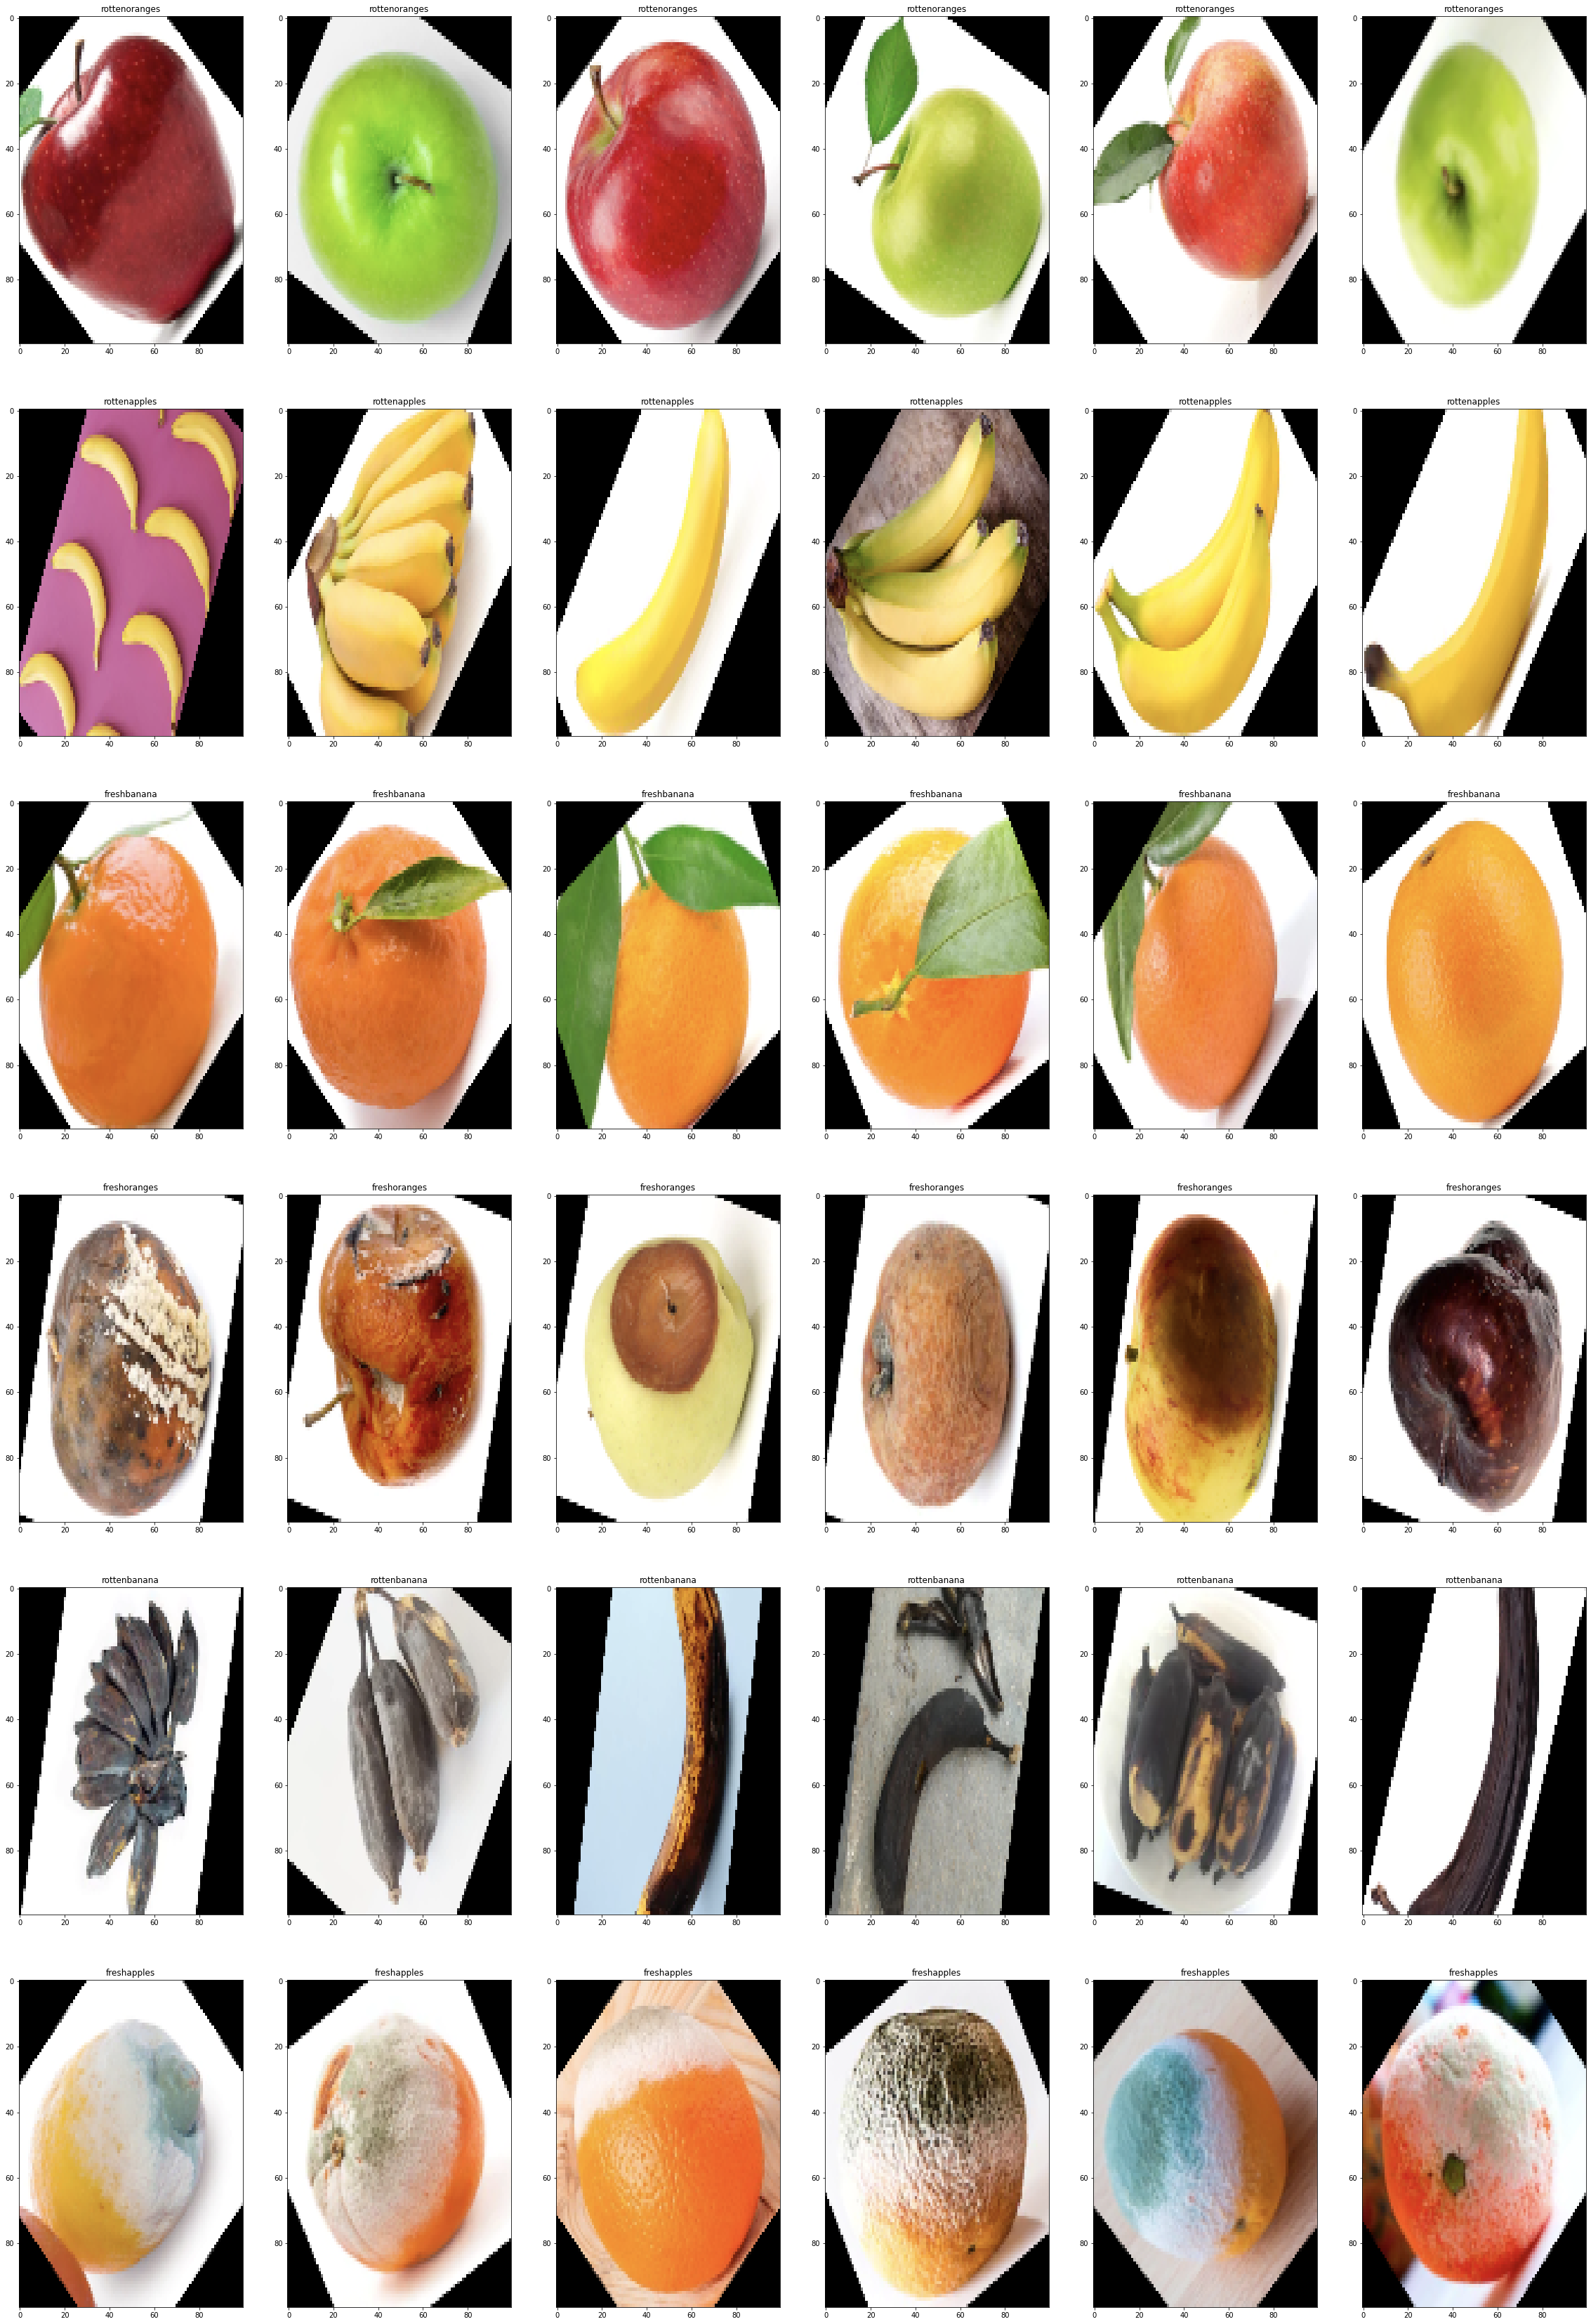

In [16]:
show_subpot(X)

In [17]:
del X

In [18]:
def load_rottenvsfresh():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/gdrive/My Drive/Kaggle/dataset/train/')):
        if quality[0] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/train/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/train/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y

In [19]:
X,Y=load_rottenvsfresh()

100%|██████████| 10901/10901 [00:00<00:00, 1487188.00it/s]

Shuffling your data.....


In [20]:
Y=np.array(Y)
X=np.array(X)

In [21]:
y_ser=pd.Series(Y)
y_ser.value_counts()

1    6161
0    4740
dtype: int64

In [22]:
def load_rottenvsfresh_valset():
    quality=['fresh', 'rotten']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/gdrive/My Drive/Kaggle/dataset/test/')):
        if quality[0] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/test/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        else:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/test/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y      

In [23]:
X_val,Y_val=load_rottenvsfresh_valset()

100%|██████████| 2698/2698 [00:00<00:00, 858721.52it/s]

Shuffling your data.....


In [24]:
Y_val=np.array(Y_val)
X_val=np.array(X_val)
y_ser=pd.Series(Y_val)
y_ser.value_counts()

1    1534
0    1164
dtype: int64

In [25]:
import keras 
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
from keras.models import Sequential

In [26]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
separable_conv2d (SeparableC (None, 100, 100, 32)      1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 50, 50, 64)        2

In [28]:
import tensorflow as tf

In [29]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/rotten.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model.compile(loss=keras.losses.binary_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [30]:
X=X/255.0
X_val=X_val/255.0

In [31]:
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_val),epochs= 50,
                 callbacks=[check_point])

Epoch 1/50
546/546 [==============================] - 37s 53ms/step - loss: 0.6864 - accuracy: 0.8370 - val_loss: 1.2141 - val_accuracy: 0.8091

Epoch 00001: val_loss improved from inf to 1.21413, saving model to /kaggle/working/rotten.h5
Epoch 2/50
546/546 [==============================] - 28s 52ms/step - loss: 0.2249 - accuracy: 0.9167 - val_loss: 0.3052 - val_accuracy: 0.9055

Epoch 00002: val_loss improved from 1.21413 to 0.30518, saving model to /kaggle/working/rotten.h5
Epoch 3/50
546/546 [==============================] - 29s 53ms/step - loss: 0.1636 - accuracy: 0.9413 - val_loss: 0.1348 - val_accuracy: 0.9548

Epoch 00003: val_loss improved from 0.30518 to 0.13477, saving model to /kaggle/working/rotten.h5
Epoch 4/50
546/546 [==============================] - 29s 53ms/step - loss: 0.1373 - accuracy: 0.9514 - val_loss: 0.1771 - val_accuracy: 0.9333

Epoch 00004: val_loss did not improve from 0.13477
Epoch 5/50
546/546 [==============================] - 29s 52ms/step - loss: 0.1

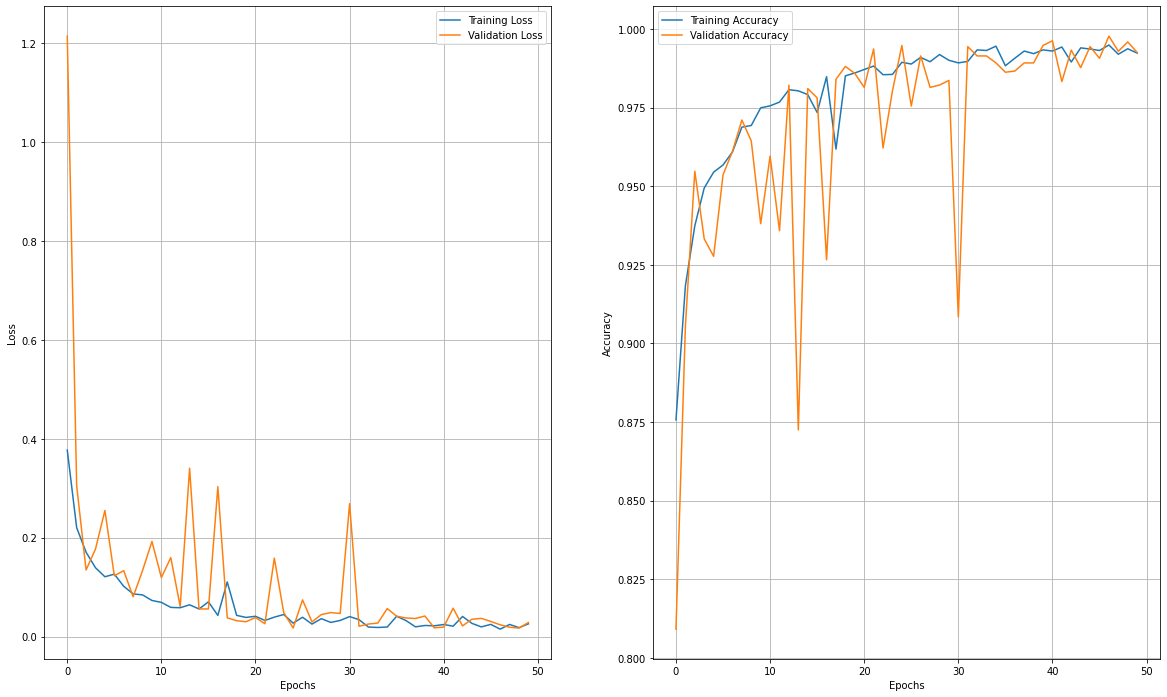

In [32]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [33]:
model.evaluate(X_val,Y_val)

85/85 [==============================] - 1s 11ms/step - loss: 0.0285 - accuracy: 0.9926


[0.028532397001981735, 0.9925870895385742]

In [34]:
model.save('./rottenvsfresh.h5')

In [35]:
from keras.models import Model, load_model

In [36]:
new_model=load_model('./rottenvsfresh.h5')

In [37]:
new_model.evaluate(X_val,Y_val)

85/85 [==============================] - 1s 10ms/step - loss: 0.0285 - accuracy: 0.9926


[0.028532397001981735, 0.9925870895385742]

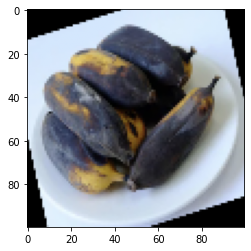

In [38]:
plt.imshow(X_val[0])

In [39]:
model.predict(X_val[0].reshape(1,100,100,3))

array([[1.]], dtype=float32)

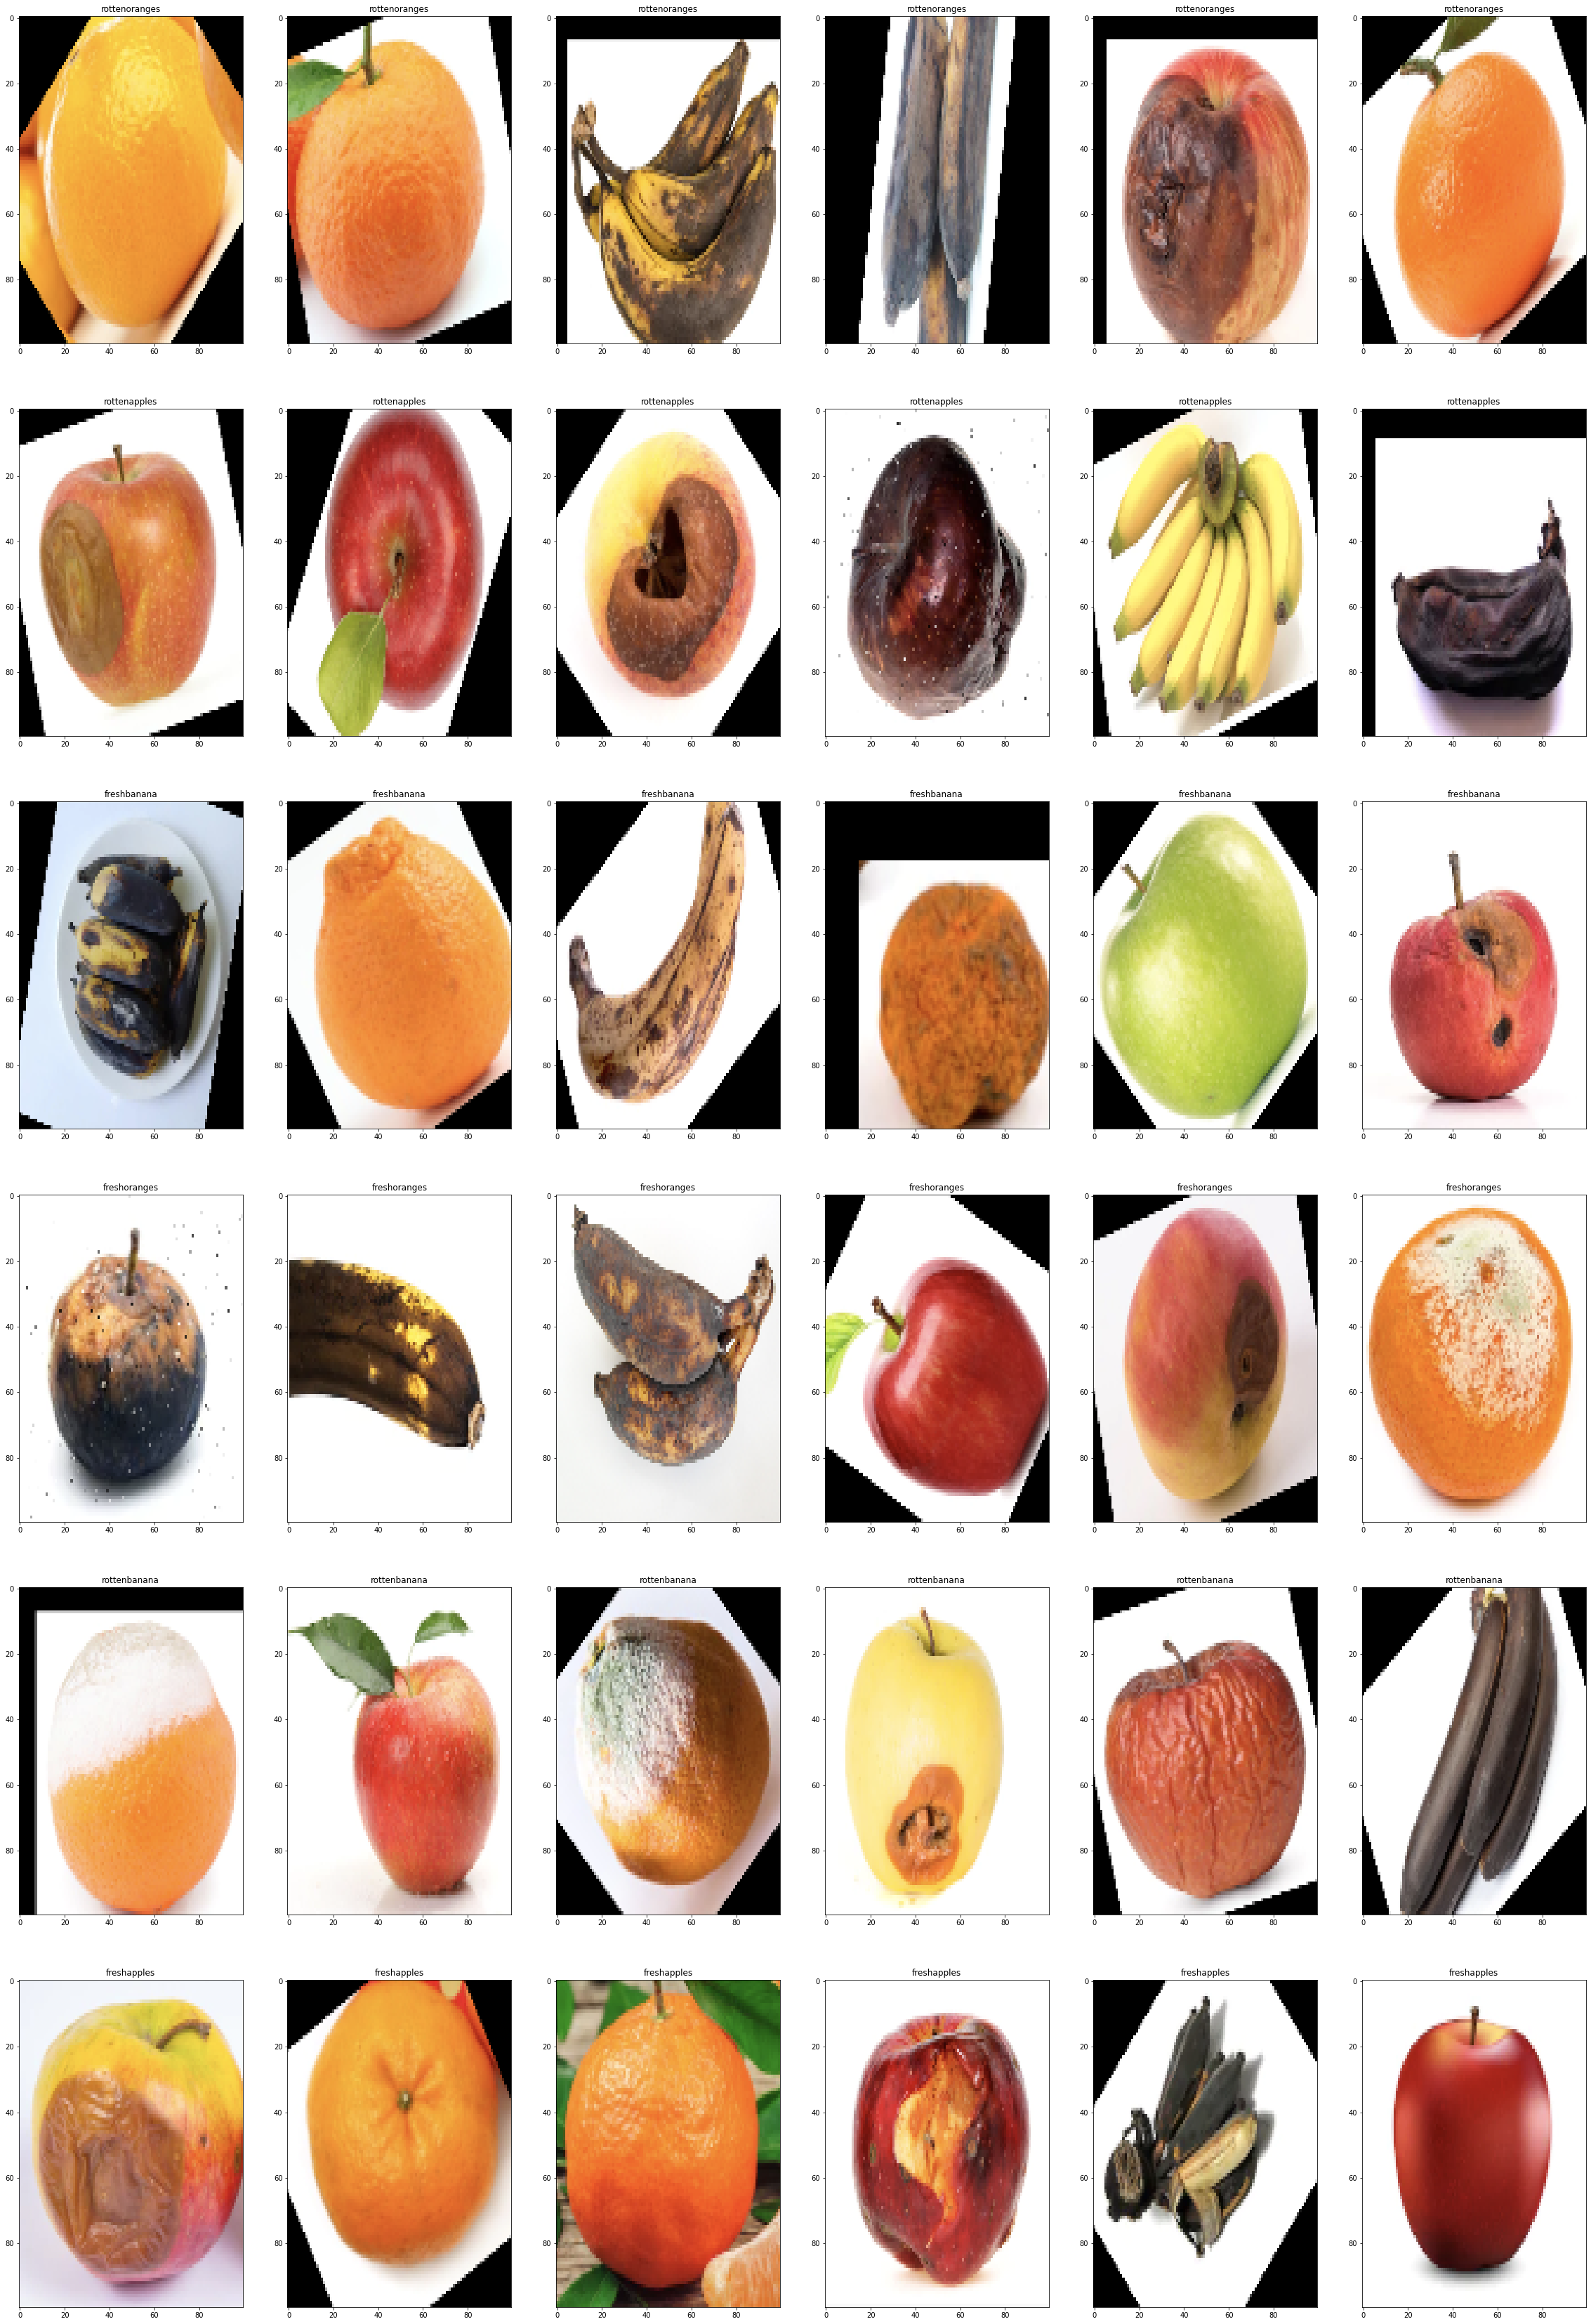

In [40]:
show_subpot(X_val[-36*11:-36*10])

In [41]:
model.predict_classes(X_val[-36*11:-36*10])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

category of fruits


In [43]:
def load_fruits_data():
    quality=['apples', 'banana','oranges']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/gdrive/My Drive/Kaggle/dataset/test/')):
        if quality[0] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/test/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        elif quality[1] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/test/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
        elif quality[2] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/test/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2])
        
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y 

In [47]:
def load_fruits_train_data():
    quality=['apples', 'banana','oranges']
    X,Y=[],[]
    z=[]
    for cata in tqdm(os.listdir('/content/gdrive/My Drive/Kaggle/dataset/train/')):
        if quality[0] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/train/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,0])
        elif quality[1] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/train/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,1])
        elif quality[2] in cata:
            path_main=os.path.join('/content/gdrive/My Drive/Kaggle/dataset/train/',cata)
            for img_name in os.listdir(path_main):
                img=cv2.imread(os.path.join(path_main,img_name))
                img=cv2.resize(img,(100,100))
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                z.append([img,2])
        
    print('Shuffling your data.....')
    shuffle(z)
    for images, labels in tqdm(z):
        X.append(images);Y.append(labels)
    return X,Y 

In [45]:
X_val,Y_val=load_fruits_data()

100%|██████████| 2698/2698 [00:00<00:00, 786833.00it/s]

Shuffling your data.....


In [48]:
X,Y=load_fruits_train_data()

100%|██████████| 10901/10901 [00:00<00:00, 1375804.41it/s]

Shuffling your data.....


In [49]:
X=np.array(X)
X_val=np.array(X_val)

In [51]:
X.shape,X_val.shape

((10901, 100, 100, 3), (2698, 100, 100, 3))

In [52]:
X=X/255.0
X_val=X_val/255.0

In [53]:
Y=to_categorical(Y)
Y

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [54]:
Y_test=to_categorical(Y_val)
Y_val=np.array(Y_val)

In [55]:
Y.shape,Y_test.shape, Y_val.shape

((10901, 3), (2698, 3), (2698,))

In [56]:
model = Sequential()

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(SeparableConv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

#model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))

In [57]:
lr_rate=keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/fruit_cata.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model.compile(loss=keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [58]:
history=model.fit(X,Y,batch_size=20,validation_data=(X_val,Y_test),epochs= 40,
                 callbacks=[check_point])

Epoch 1/40
546/546 [==============================] - 34s 60ms/step - loss: 0.4435 - accuracy: 0.8158 - val_loss: 0.7609 - val_accuracy: 0.6898

Epoch 00001: val_loss improved from inf to 0.76086, saving model to /kaggle/working/fruit_cata.h5
Epoch 2/40
546/546 [==============================] - 32s 59ms/step - loss: 0.1711 - accuracy: 0.9371 - val_loss: 0.1346 - val_accuracy: 0.9474

Epoch 00002: val_loss improved from 0.76086 to 0.13457, saving model to /kaggle/working/fruit_cata.h5
Epoch 3/40
546/546 [==============================] - 32s 59ms/step - loss: 0.2037 - accuracy: 0.9221 - val_loss: 0.1649 - val_accuracy: 0.9407

Epoch 00003: val_loss did not improve from 0.13457
Epoch 4/40
546/546 [==============================] - 32s 59ms/step - loss: 0.1298 - accuracy: 0.9538 - val_loss: 0.4795 - val_accuracy: 0.8347

Epoch 00004: val_loss did not improve from 0.13457
Epoch 5/40
546/546 [==============================] - 32s 59ms/step - loss: 0.1184 - accuracy: 0.9593 - val_loss: 2.61

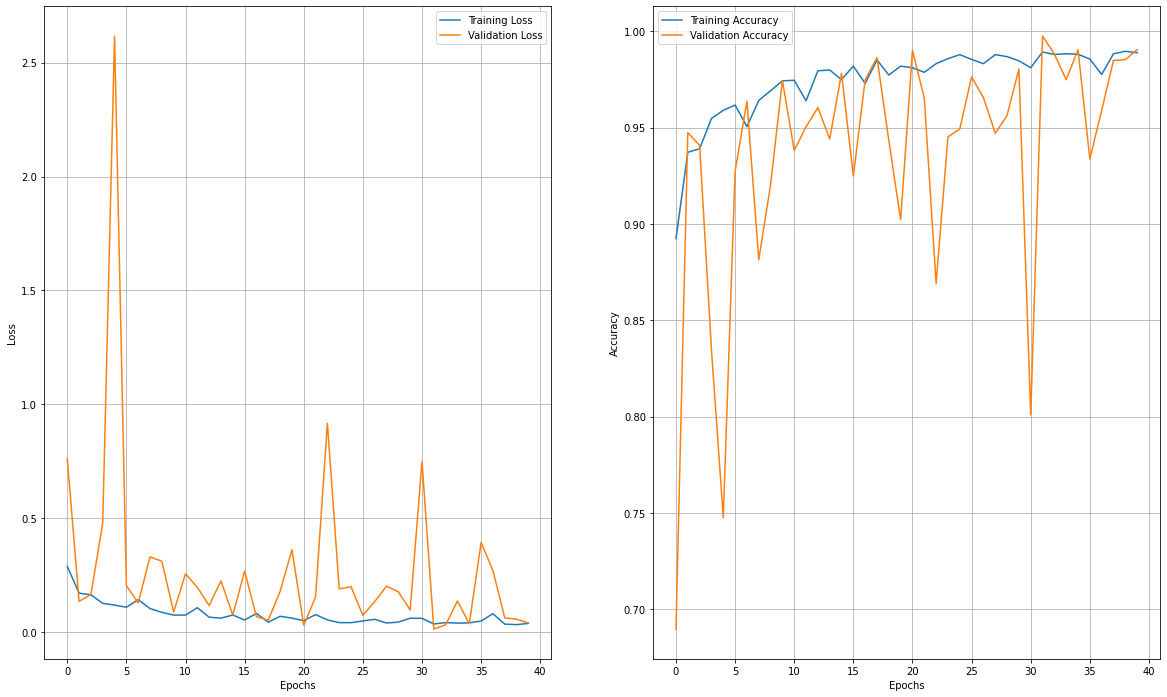

In [59]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [61]:
model.save('./fruit_cata.h5')

In [62]:
model2=load_model('./fruit_cata.h5')

In [63]:
model2.evaluate(X,Y)

341/341 [==============================] - 4s 11ms/step - loss: 0.0199 - accuracy: 0.9946


[0.019857564941048622, 0.9945876598358154]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


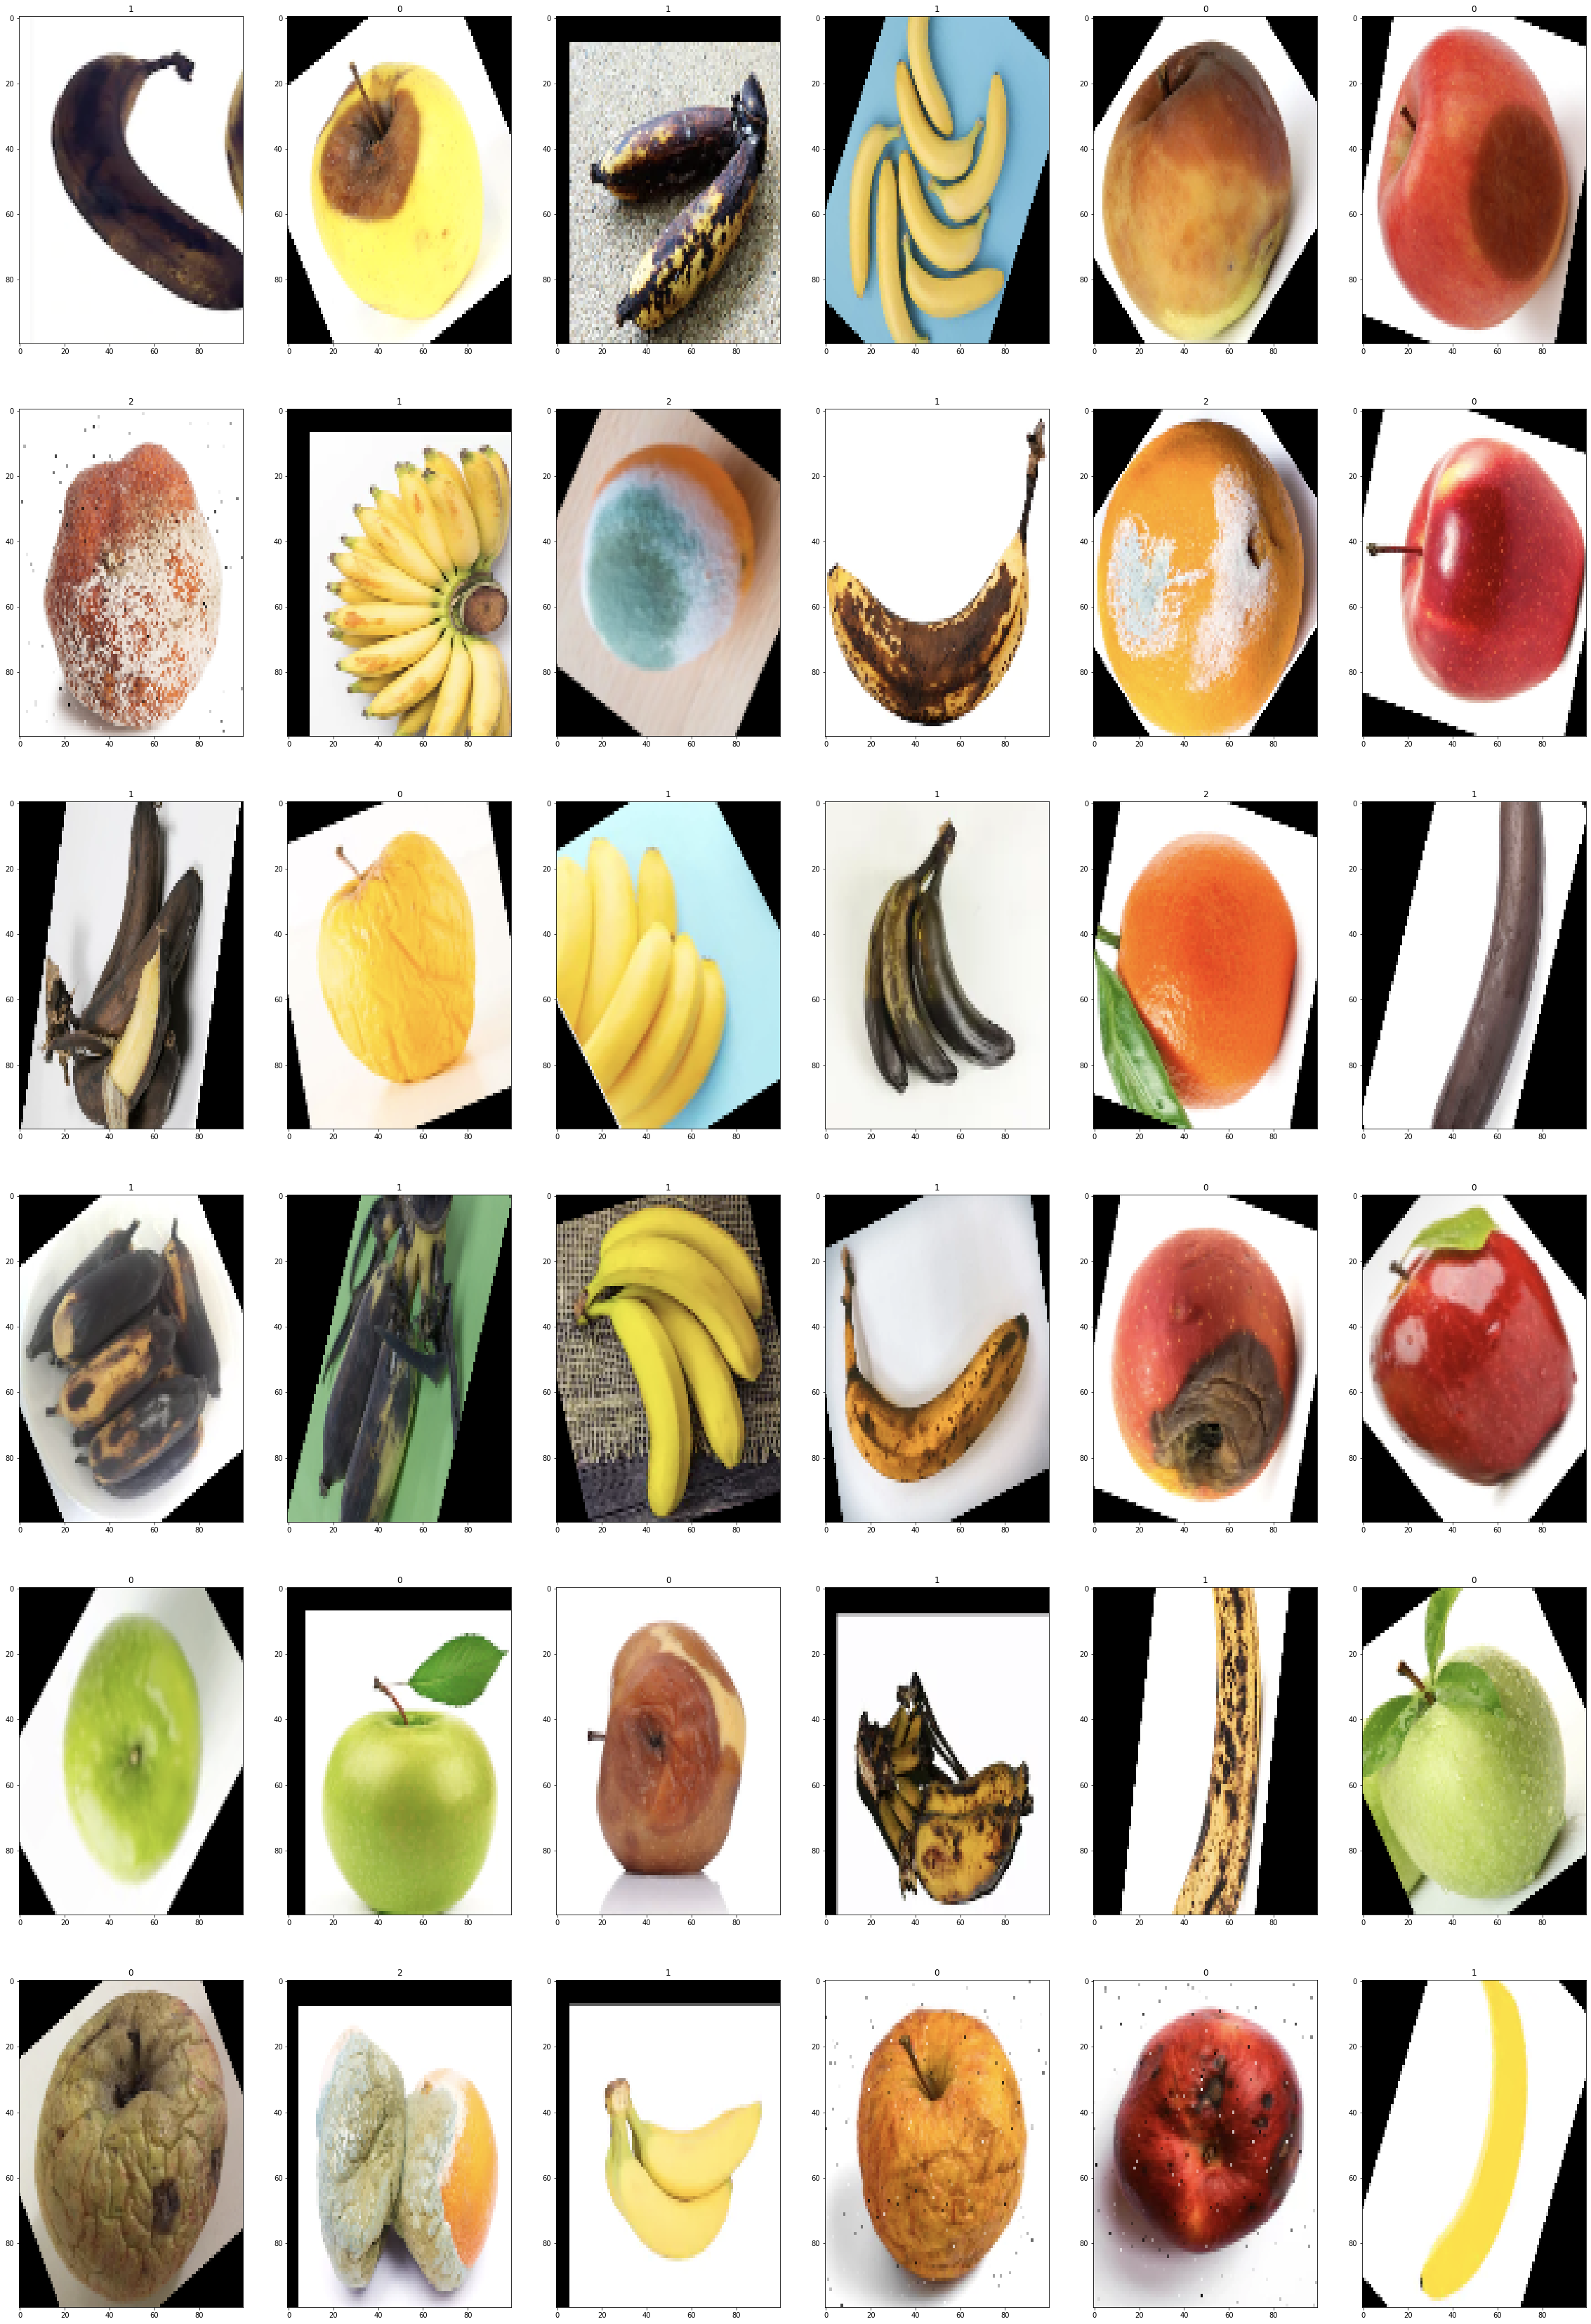

In [64]:
show_subpot(X_val[:36],title=True,Y=model2.predict_classes(X_val[:36]))

In [65]:
model2.predict_classes(X_val[:36])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1, 0, 1, 1, 0, 0, 2, 1, 2, 1, 2, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1])

In [70]:
model2.predict_classes(X_val[:1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1])